In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity_cosine"

In [3]:
dataset = "2020-10-18-0"
estim = "data003/data003-all"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [4]:
wnoise = "kilosort_data000/data000"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [5]:
patterns = np.array([2])
n = 12

p_thr = 2/19
p_upper = 1
random_state = 0
print(vcd.get_cell_type_for_cell(n))

ON parasol


In [6]:
all_elecs = []

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]
    all_elecs.append(triplet_elecs)

Pattern 2


In [7]:
len(good_inds)

939

/tmp/ipykernel_31641/1297822682.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


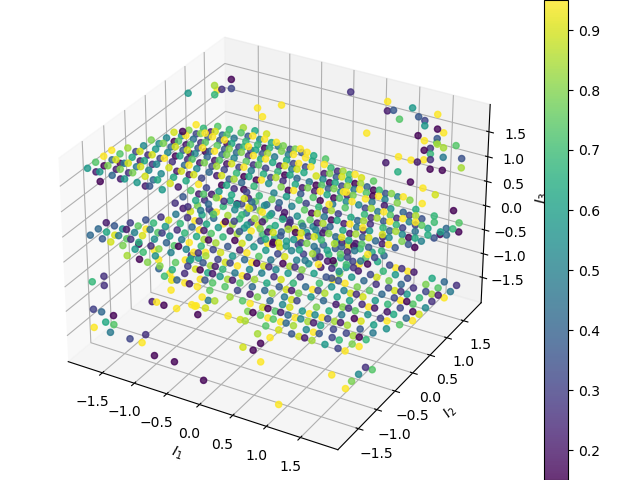

In [8]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)

clb = plt.colorbar(scat)
plt.show()

In [9]:
clustering = SpectralClustering(n_clusters=2, 
                                assign_labels='discretize', 
                                affinity='nearest_neighbors', 
                                random_state=random_state).fit(amplitudes[good_inds])

/Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/tmp/ipykernel_31641/933349295.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


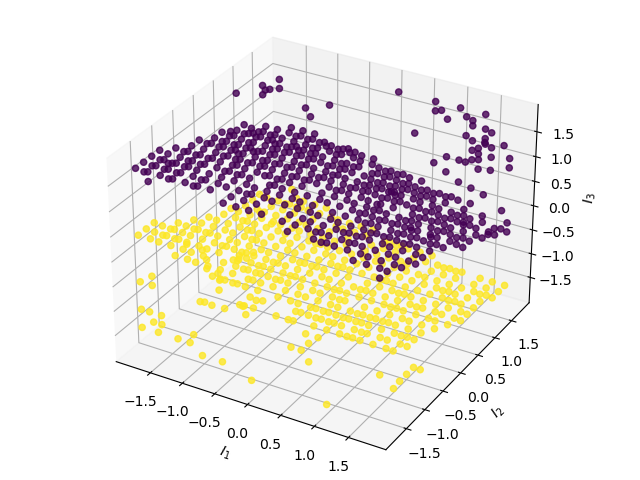

In [10]:
fig = plt.figure(1)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=clustering.labels_, alpha=0.8)

plt.show()

In [11]:
all_elecs_array = np.unique(np.array(all_elecs))

In [12]:
all_elecs_array

array([  5,   6, 517], dtype=uint16)

In [13]:
X_all = []
y_all = []
trials_all = []

In [14]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            triplet_trials[k] = prob_dict["num_trials"]
    
    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)
    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]
    trials = triplet_trials[good_inds]
    X_all_p = np.zeros((len(good_inds), len(all_elecs_array)))
    X_all_p[:, elec_inds] = X
    X_all.append(X_all_p)
    y_all.append(y)
    trials_all.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[good_inds])
    print(X_all_p)
    print(y)
    print(trials)

Pattern 2
[  5   6 517]
[517   5   6]
[2 0 1]
[[-1.78125 -0.46875 -0.09375]
 [-1.40625 -0.65625 -0.09375]
 [-1.59375 -0.65625 -0.09375]
 ...
 [ 0.65625  1.78125  1.78125]
 [ 1.03125  1.78125  1.78125]
 [ 1.40625  1.78125  1.78125]]
[[-0.46875 -0.09375 -1.78125]
 [-0.65625 -0.09375 -1.40625]
 [-0.65625 -0.09375 -1.59375]
 ...
 [ 1.78125  1.78125  0.65625]
 [ 1.78125  1.78125  1.03125]
 [ 1.78125  1.78125  1.40625]]
[0.35       0.3        0.45       0.75       0.15       0.4
 0.55       0.9        0.5        0.8        0.2        0.15
 0.3        0.75       0.35       0.75       0.95       0.95
 0.95       0.95       0.85       0.15       0.35       0.3
 0.6        0.6        0.3        0.35       0.7        0.65
 0.15       0.35       0.5        0.8        0.95       0.26315789
 0.26315789 0.57894737 0.68421053 0.47368421 0.57894737 0.73684211
 0.94736842 0.26315789 0.52631579 0.73684211 0.21052632 0.36842105
 0.63157895 0.21052632 0.57894737 0.63157895 0.89473684 0.73684211
 0.73684211

In [15]:
all_amps = np.vstack(X_all)
all_probs = np.hstack(y_all)
all_trials = np.hstack(trials_all)

In [16]:
all_amps.shape, all_probs.shape, all_trials.shape

((939, 3), (939,), (939,))

In [17]:
clustering = SpectralClustering(n_clusters=2, 
                                assign_labels='discretize',
                                affinity='nearest_neighbors', 
                                random_state=random_state).fit(all_amps)

cluster1 = np.where(clustering.labels_ == 0)[0]
cluster2 = np.where(clustering.labels_ == 1)[0]

/Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [18]:
all_amps_pos = all_amps[cluster1]
all_amps_neg = all_amps[cluster2]

all_probs_pos = all_probs[cluster1]
all_probs_neg = all_probs[cluster2]

trials_pos = all_trials[cluster1]
trials_neg = all_trials[cluster2]

/tmp/ipykernel_31641/2877820637.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


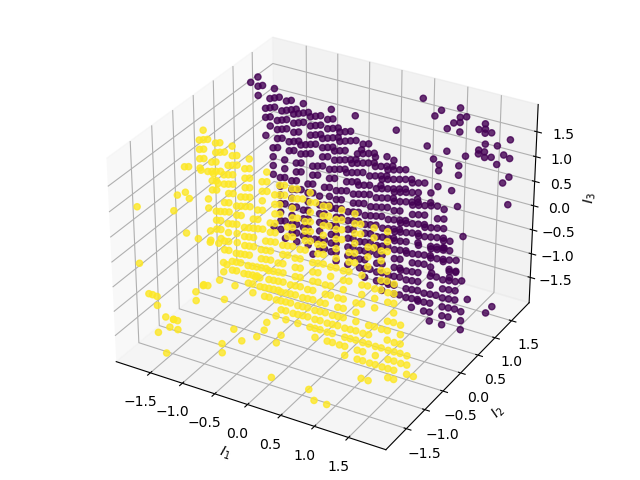

In [19]:
fig = plt.figure(68)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(all_amps[:, 0], 
            all_amps[:, 1],
            all_amps[:, 2], marker='o', s=20, c=clustering.labels_, alpha=0.8)

plt.show()

In [20]:
test_size = 0.2
train_amps_pos, test_amps_pos, train_probs_pos, test_probs_pos, train_trials_pos, _ = train_test_split(all_amps_pos, all_probs_pos, trials_pos, test_size=test_size)
train_amps_neg, test_amps_neg, train_probs_neg, test_probs_neg, train_trials_neg, _ = train_test_split(all_amps_neg, all_probs_neg, trials_neg, test_size=test_size)

In [21]:
def MSE(y1, y2):
    assert len(y1) == len(y2)
    
    return np.sum((y1 - y2)**2) / len(y1)

In [31]:
l2_reg = 0.01

degrees = np.arange(5) + 1
train_accuracy = np.zeros(len(degrees))
test_accuracy = np.zeros(len(degrees))

train_error = np.zeros(len(degrees))
test_error = np.zeros(len(degrees))

for i in range(len(degrees)):
    degree = degrees[i]
    poly = PolynomialFeatures(degree)

    OLS_X = poly.fit_transform(train_amps_neg)
    OLS_X_test = poly.fit_transform(test_amps_neg)
    OLS_y = np.log(train_probs_neg / (1 - train_probs_neg))
    OLS_y_test = np.log(test_probs_neg / (1 - test_probs_neg))

    OLS_w = (np.linalg.inv(l2_reg * np.eye(OLS_X.shape[-1]) + OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    print(OLS_w)

    train_acc, test_acc = (np.mean(np.absolute(fitting.fsigmoid(OLS_X, OLS_w) - train_probs_neg) < 0.1), 
                           np.mean(np.absolute(fitting.fsigmoid(OLS_X_test, OLS_w) - test_probs_neg) < 0.1))
    
    train_err = MSE(OLS_y, OLS_X @ OLS_w)
    test_err = MSE(OLS_y_test, OLS_X_test @ OLS_w)
    
    train_accuracy[i] = train_acc
    test_accuracy[i] = test_acc
    
    train_error[i] = train_err
    test_error[i] = test_err

[ 0.0270939  -0.26827109 -0.48014103 -0.06152339]
[-5.50811656 -4.08076405 -9.98643323 -2.23493311 -0.43352107 -2.82967662
 -0.5813262  -3.16396671 -1.47846204 -0.16337216]
[-18.22224465 -17.07611276 -35.2941444  -11.18371492  -4.14969142
 -19.05904305  -6.91989398 -16.33756165 -13.68422263  -1.22541178
  -0.23022083  -2.21310351  -0.93016427  -4.19830163  -4.50130748
  -0.28735265  -1.71738053  -3.76132427  -0.36134935   0.09217929]
[-18.62973418 -11.91333216 -30.00378963  -8.55329112   3.69029
  -1.03421335  -0.72705003  -8.75154995  -6.83899221   0.75092921
   3.00419676  10.73177024   2.5113671    9.83700911   6.06919917
   2.25835575  -0.34679625  -0.43230668   0.54469902   0.27862002
   0.282405     2.64125132   0.56754303   4.07251229   2.26681585
   0.56654029   2.01217675   3.35169606   1.99353415   0.34137613
   0.06632701   0.25785158  -0.83496329  -0.15065606  -0.11561337]
[-1.53589890e+01 -1.20642873e+01 -2.38072222e+01 -5.75373398e+00
 -3.17688232e+00 -1.48376213e+00  4.2

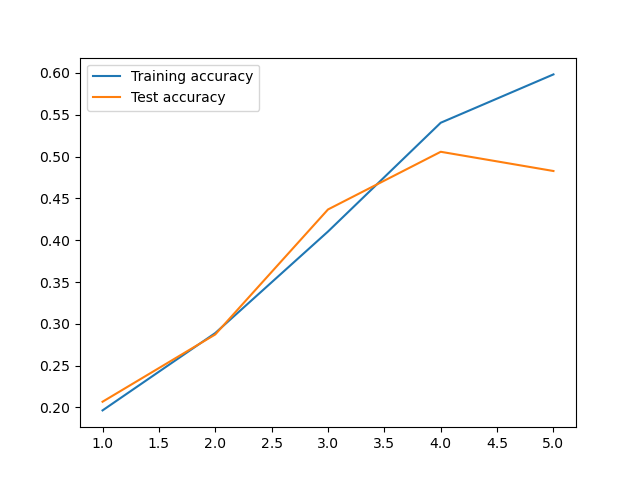

In [32]:
fig = plt.figure(20)
fig.clear()
plt.plot(degrees, train_accuracy, label='Training accuracy')
plt.plot(degrees, test_accuracy, label='Test accuracy')
plt.legend()
plt.show()

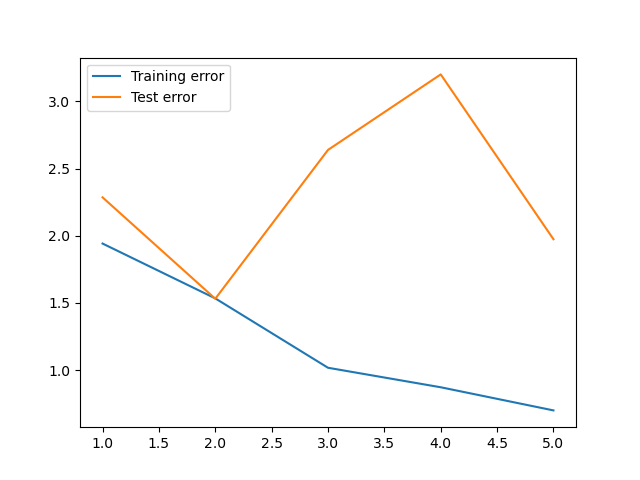

In [33]:
fig = plt.figure(29)
fig.clear()
plt.plot(degrees, train_error, label='Training error')
plt.plot(degrees, test_error, label='Test error')
plt.legend()
plt.show()

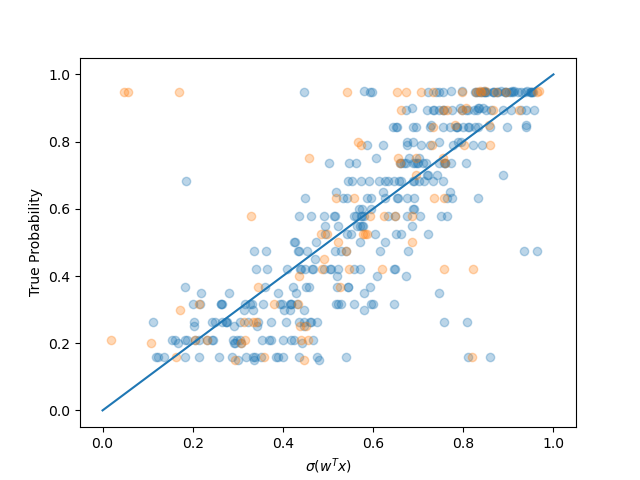

In [34]:
fig = plt.figure(12)
fig.clear()
plt.scatter(fitting.fsigmoid(OLS_X, OLS_w), train_probs_neg, alpha=0.3)
plt.scatter(fitting.fsigmoid(OLS_X_test, OLS_w), test_probs_neg, alpha=0.3)
plt.xlabel(r'$\sigma(w^Tx)$')
plt.ylabel('True Probability')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

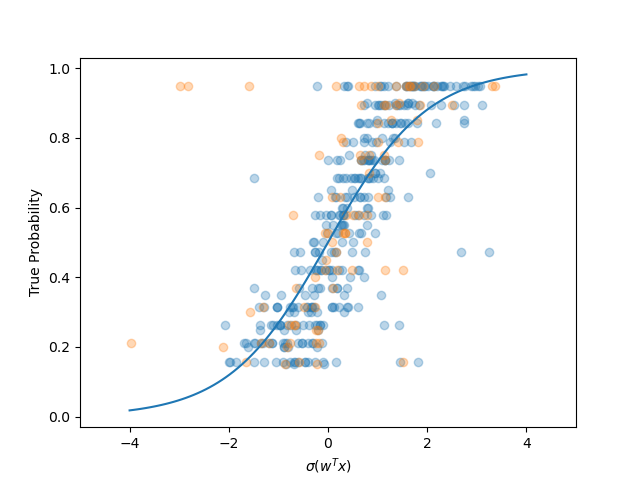

In [35]:
fig = plt.figure(15)
fig.clear()
plt.scatter(OLS_X @ OLS_w, train_probs_neg, alpha=0.3)
plt.scatter(OLS_X_test @ OLS_w, test_probs_neg, alpha=0.3)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.xlabel(r'$\sigma(w^Tx)$')
plt.ylabel('True Probability')
plt.xlim(-5, 5)
plt.show()

In [ ]:
np.mean(np.absolute(fitting.fsigmoid(OLS_X, OLS_w) - train_probs_neg) < 0.1), np.mean(np.absolute(fitting.fsigmoid(OLS_X_test, OLS_w) - test_probs_neg) < 0.1)

In [ ]:
l2_reg = 0.01

degrees = np.arange(1) + 1
train_accuracy = np.zeros(len(degrees))
test_accuracy = np.zeros(len(degrees))

train_error = np.zeros(len(degrees))
test_error = np.zeros(len(degrees))

for i in range(len(degrees)):
    degree = degrees[i]
    poly = PolynomialFeatures(degree)

    OLS_X = poly.fit_transform(train_amps_pos)
    OLS_X_test = poly.fit_transform(test_amps_pos)
    OLS_y = np.log(train_probs_pos / (1 - train_probs_pos))
    OLS_y_test = np.log(test_probs_pos / (1 - test_probs_pos))

    OLS_w = (np.linalg.inv(l2_reg * np.eye(OLS_X.shape[-1]) + OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    print(OLS_w)

    train_acc, test_acc = (np.mean(np.absolute(fitting.fsigmoid(OLS_X, OLS_w) - train_probs_pos) < 0.1), 
                           np.mean(np.absolute(fitting.fsigmoid(OLS_X_test, OLS_w) - test_probs_pos) < 0.1))
    
    train_err = MSE(OLS_y, OLS_X @ OLS_w)
    test_err = MSE(OLS_y_test, OLS_X_test @ OLS_w)
    
    train_accuracy[i] = train_acc
    test_accuracy[i] = test_acc
    
    train_error[i] = train_err
    test_error[i] = test_err

In [ ]:
fig = plt.figure(21)
fig.clear()
plt.plot(degrees, train_accuracy, label='Training accuracy')
plt.plot(degrees, test_accuracy, label='Test accuracy')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(39)
fig.clear()
plt.plot(degrees, train_error, label='Training error')
plt.plot(degrees, test_error, label='Test error')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(13)
fig.clear()
plt.scatter(fitting.fsigmoid(OLS_X, OLS_w), train_probs_pos, alpha=0.3)
plt.scatter(fitting.fsigmoid(OLS_X_test, OLS_w), test_probs_pos, alpha=0.3)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

In [ ]:
fig = plt.figure(16)
fig.clear()
plt.scatter(OLS_X @ OLS_w, train_probs_pos, alpha=0.3)
plt.scatter(OLS_X_test @ OLS_w, test_probs_pos, alpha=0.3)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.xlabel(r'$\sigma(w^Tx)$')
plt.ylabel('True Probability')
plt.xlim(-5, 5)
plt.show()

In [ ]:
np.mean(np.absolute(fitting.fsigmoid(OLS_X, OLS_w) - train_probs_pos) < 0.1), np.mean(np.absolute(fitting.fsigmoid(OLS_X_test, OLS_w) - test_probs_pos) < 0.1)